# Demo Code for ATE

We assume the following nuisance functions:

- The **outcome regression** functions:
  $$
  m_0(x) = \mathbb{E}[Y \mid T = 0, X = x], \quad
  m_1(x) = \mathbb{E}[Y \mid T = 1, X = x]
  $$

- The **propensity score**:
  $$
  e(x) = \mathbb{P}(T = 1 \mid X = x)
  $$

Let their corresponding estimators be:

- Estimated outcome regressions:
  $$
  \hat m_0(x) \approx \mathbb{E}[Y \mid T = 0, X = x], \quad
  \hat m_1(x) \approx \mathbb{E}[Y \mid T = 1, X = x]
  $$

- Estimated propensity score:
  $$
  \hat e(x) \approx \mathbb{P}(T = 1 \mid X = x)
  $$


We model the random differences between the true and estimated functions using the function `noisy_estimate`.



## Theoretical Results
We assume convergence rates:

$$
\|\hat m_0 - m_0\| = O_p\left(n^{-r_0}\right), \quad
\|\hat m_1 - m_1\| = O_p\left(n^{-r_1}\right), \quad
\|\hat e   - e   \| = O_p\left(n^{-r_e}\right)
$$

Define:

$$
r = \min(r_0, r_1)
$$

Note that the convergence rates are determined by the (decay of the) bias of and the noise of the estimators. In this notebook we also determine them empirically.



## T-Learner Requirement

The T-Learner computes the average treatment effect by:

$$
\hat\theta_{\text{T}} = \frac{1}{n} \sum_{i=1}^n \left[ \hat m_1(X_i) - \hat m_0(X_i) \right]
$$

Its bias scales as:

$$
O_p(n^{-r})
$$

To achieve consistency — which entails that the ATE estimate converges to the true value and becomes asymptotically unbiased — we require:

$$
\boxed{r > 0.5}
$$



## Doubly-Robust (DR) / AIPW Estimator

The DR estimator is defined as:

$$
\hat\theta_{\text{DR}} = \frac{1}{n} \sum_{i=1}^n \left[
\frac{T_i - \hat e(X_i)}{\hat e(X_i)(1 - \hat e(X_i))} (Y_i - \hat m_{T_i}(X_i)) +
\left(\hat m_1(X_i) - \hat m_0(X_i)\right)
\right]
$$

Its bias is of the form:

$$
O_p(n^{-r}) + O_p(n^{-(r + r_e)}) \approx O_p(n^{-(r + r_e)})
$$

So to achieve concitency it is sufficient that:

$$
\boxed{r + r_e > 0.5}
$$

This is the key advantage of doubly robust estimators: they remain consistent as long as *either* the outcome models or the propensity model is estimated sufficiently well.

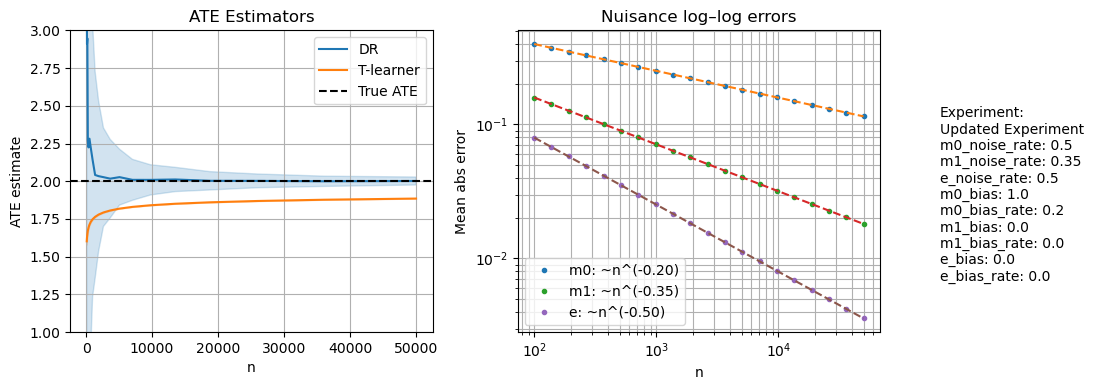

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#–– Configuration ––#
num_runs   = 500
theta_true = 2.0
n_values = np.logspace(np.log10(100), np.log10(50000), 20, dtype=int)

# Experiment settings: tune these
experiment = {
    "label"          : "Updated Experiment",
    "m0_noise_rate"  : 0.5,
    "m1_noise_rate"  : 0.35,
    "e_noise_rate"   : 0.5,
    "m0_bias"        : 1.0,
    "m0_bias_rate"   : 0.2, 
    "m1_bias"        : 0.0,
    "m1_bias_rate"   : 0.0,
    "e_bias"         : 0.0,
    "e_bias_rate"    : 0.0,
}

#–– True functions ––#
def m_true(x): return np.sin(x)
def e_true(x): return 1 / (1 + np.exp(-2 * x))

#–– Noisy + biased estimator ––#
def noisy_estimate(true_func, x,
                   noise_rate, bias_mag=0.0, bias_rate=0.0):
    """
    Simulate \hat f(x) = true_func(x) + noise + decaying_bias
      noise ~ N(0,1)*n^{-noise_rate}
      decaying_bias = bias_mag * n^{-bias_rate}
    """
    n = len(x)
    noise = np.random.normal(0, 1, size=x.shape) * (n ** -noise_rate)
    decaying_bias = bias_mag * (n ** -bias_rate)
    return true_func(x) + noise + decaying_bias

#–– DR‐ATE estimator ––#
def estimate_dr_ate(Y, T, e_hat, m0_hat, m1_hat, clip_eps=1e-3):
    e = np.clip(e_hat.reshape(-1,1), clip_eps, 1-clip_eps)
    m_hat = T * m1_hat + (1 - T) * m0_hat
    score = ((T - e) / (e * (1 - e))) * (Y - m_hat) + (m1_hat - m0_hat)
    return float(np.mean(score))

#–– Run one experiment ––#
def run_experiment(cfg):
    R = len(n_values)
    dr_arr = np.zeros((num_runs, R))
    t_arr  = np.zeros((num_runs, R))
    err_m0 = np.zeros((num_runs, R))
    err_m1 = np.zeros((num_runs, R))
    err_e  = np.zeros((num_runs, R))
    
    for i in range(num_runs):
        for j, n in enumerate(n_values):
            X = np.random.normal(0, 1, size=(n, 1))
            T = np.random.binomial(1, e_true(X))
            Y = theta_true * T + m_true(X) + np.random.normal(0, 1, size=(n, 1))
            
            # fit nuisances
            m0_hat = noisy_estimate(m_true, X,
                        cfg["m0_noise_rate"],
                        cfg["m0_bias"], cfg["m0_bias_rate"])
            m1_hat = noisy_estimate(m_true, X,
                        cfg["m1_noise_rate"],
                        cfg["m1_bias"], cfg["m1_bias_rate"]) + theta_true
            e_hat  = noisy_estimate(e_true, X,
                        cfg["e_noise_rate"],
                        cfg["e_bias"], cfg["e_bias_rate"])
            
            # ATE
            dr_arr[i,j] = estimate_dr_ate(Y, T, e_hat, m0_hat, m1_hat)
            t_arr[i,j]  = np.mean(m1_hat - m0_hat)
            
            # nuisance MAE
            err_m0[i,j] = np.mean(np.abs(m0_hat - m_true(X)))
            err_m1[i,j] = np.mean(np.abs((m1_hat - theta_true) - m_true(X)))
            err_e[i,j]  = np.mean(np.abs(e_hat - e_true(X)))
    
    return {
        "dr_mean": dr_arr.mean(0), "dr_std": dr_arr.std(0),
        "t_mean" : t_arr.mean(0),  "t_std" : t_arr.std(0),
        "m0_err_mean": err_m0.mean(0), "m0_err_std": err_m0.std(0),
        "m1_err_mean": err_m1.mean(0), "m1_err_std": err_m1.std(0),
        "e_err_mean" : err_e.mean(0),  "e_err_std" : err_e.std(0),
    }

#–– Main ––#
stats = run_experiment(experiment)

# Plot ATE estimators
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(n_values, stats["dr_mean"], label="DR", color="C0")
plt.fill_between(n_values, stats["dr_mean"]-stats["dr_std"],
                          stats["dr_mean"]+stats["dr_std"],
                          alpha=0.2, color="C0")
plt.plot(n_values, stats["t_mean"], label="T-learner", color="C1")
plt.fill_between(n_values, stats["t_mean"]-stats["t_std"],
                          stats["t_mean"]+stats["t_std"],
                          alpha=0.2, color="C1")
plt.axhline(theta_true, linestyle="--", color="k", label="True ATE")
plt.xlabel("n"); plt.ylabel("ATE estimate")
plt.ylim(1,3)
plt.title("ATE Estimators"); plt.legend(); plt.grid(True)

# Plot and fit log-log errors
plt.subplot(1,2,2)
for name, err_key in [("m0", "m0_err_mean"), ("m1", "m1_err_mean"), ("e", "e_err_mean")]:
    err = stats[err_key]
    log_n   = np.log(n_values).reshape(-1,1)
    log_err = np.log(err)
    lr = LinearRegression().fit(log_n, log_err)
    slope = lr.coef_[0]
    C_est  = np.exp(lr.intercept_)
    plt.plot(n_values, err, '.', label=f"{name}: ~n^({slope:.2f})")
    plt.plot(n_values, C_est * n_values**(slope), '--')
    
plt.xscale('log'); plt.yscale('log')
plt.xlabel("n"); plt.ylabel("Mean abs error")
plt.title("Nuisance log–log errors")
plt.legend(); plt.grid(True, which="both")

# Add text to the right side of the plot
plt.gcf().text(1.05, 0.5, f"Experiment:\n{experiment['label']}\n"
                          f"m0_noise_rate: {experiment['m0_noise_rate']}\n"
                          f"m1_noise_rate: {experiment['m1_noise_rate']}\n"
                          f"e_noise_rate: {experiment['e_noise_rate']}\n"
                          f"m0_bias: {experiment['m0_bias']}\n"
                          f"m0_bias_rate: {experiment['m0_bias_rate']}\n"
                          f"m1_bias: {experiment['m1_bias']}\n"
                          f"m1_bias_rate: {experiment['m1_bias_rate']}\n"
                          f"e_bias: {experiment['e_bias']}\n"
                          f"e_bias_rate: {experiment['e_bias_rate']}",
             fontsize=10, ha='left', va='center', transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show()